<a href="https://colab.research.google.com/github/rbbh/Forecasting-Time-Series-with-Hybrid-Algorithms/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [4]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [0]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))

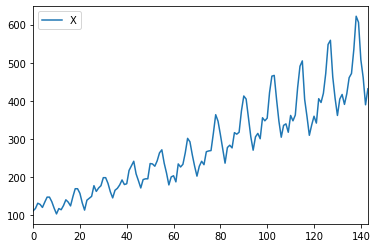

In [6]:
data.plot()


In [7]:
# TODO: Create function for the Lag used for the prediction
# We will use 12 for the lag dimension if the series repeats 
# itself annually, 3 if it is trimestrial etc.

dimensions = 12
data_c = pd.concat([data.shift(i) for i in range(0 + dimensions + 1)], axis = 1)
print(data_c)

       X      X      X      X      X  ...      X      X      X      X      X
0    112    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
1    118  112.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2    132  118.0  112.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3    129  132.0  118.0  112.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
4    121  129.0  132.0  118.0  112.0  ...    NaN    NaN    NaN    NaN    NaN
..   ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
139  606  622.0  535.0  472.0  461.0  ...  405.0  362.0  407.0  463.0  559.0
140  508  606.0  622.0  535.0  472.0  ...  417.0  405.0  362.0  407.0  463.0
141  461  508.0  606.0  622.0  535.0  ...  391.0  417.0  405.0  362.0  407.0
142  390  461.0  508.0  606.0  622.0  ...  419.0  391.0  417.0  405.0  362.0
143  432  390.0  461.0  508.0  606.0  ...  461.0  419.0  391.0  417.0  405.0

[144 rows x 13 columns]


In [0]:
# Normalizing the data
data_c = data_c/data_c.max() 

In [9]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_c.iloc[12:,1:]
y = data_c.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))



26
27
79


In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-1
    max_e = 1e-1
    min_e = 1e-4
    max_g = 1e0
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    # TODO: Create function for thresholds
    threshold = 10e100
    threshold2 = 10e100
    threshold3 = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    g_bests = []
    g1 = []
    g2 = []
    g3 = []
    population_av = []
    for i in range(iterations):
        #av_pbest = []
        #population = []
        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best position to the Group's best
              g_best = p_best[aux].copy()
              

          #p_bests.append(p_best[j])  


        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
            #population.append(c)

        #population_av.append(sum(population)/n_particles)

        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val
        g_bests.append(g_best)  

        
        print('Best value iteration # %d = %f\n'%(i, g_best_val))

  
    # The variable below represents the average of all group's best
    # locations  
    av_gbest = sum(g_bests)/iterations

    print('\n')
    print(color.BOLD + 'Predictions from the group´s Average in the validation set:\n' + color.END)
    predict(av_gbest)
    
    for m in range(len(g_bests)):
      g1.append(g_bests[m][0])
      g2.append(g_bests[m][1])
      g3.append(g_bests[m][2]) 

    import statistics as st

    m1 = st.median(g1)
    m2 = st.median(g2)
    m3 = st.median(g3)

    median_gbest = np.array([m1,m2,m3])

  
    print(color.BOLD + 'Predictions from the group´s Median in the validation set:\n' + color.END)
    predict(median_gbest)
 

    # Coordinates found after all the iterations
    print('Group Best configuration found: ')
    print(g_best)
    print('\n')
    print('Average Group Best configuration found: ')
    print(av_gbest)
    print('\n')
    print('Median Group Best configuration found: ')
    print(median_gbest)
    print('\n')


    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test = bestRGS.predict(X_test)

    # Displaying actual values and predicted values for
    # Group's best configuration found overall

    print(color.BOLD + 'Predictions with the Population Best Value found:\n' + color.END)
    evaluate(g_best)  
      
    # Displaying actual values and predicted values for
    # the Group's best configuration's average throughout
    # the iterations

    print(color.BOLD + 'Predictions with the Average Best Group Value found:\n' + color.END)
    evaluate(av_gbest)
    
    # Displaying actual values and predicted values for
    # the Group's best configuration's median values
 
    print(color.BOLD + 'Predictions with the Median Group Value found:\n' + color.END)
    evaluate(median_gbest)
            


In [0]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'



In [0]:
# Function that displays tridimensional plot
def plot(some_list):
 
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

  print('\n')
  print('\n')

In [0]:
def predict(coordinates):
 
  from sklearn.metrics import mean_squared_error

  rgs = svm.SVR(C = coordinates[0], epsilon = coordinates[1], gamma = coordinates[2])
  rgs.fit(X_train, y_train)
  y_predict = rgs.predict(X_val)
 
  #Un-normalizing the data 
  #y_val = y_val*data_c.max()
  #y_predict = y_predict*data_c.max()

  mse = mean_squared_error(y_val, y_predict)
  predict_test = rgs.predict(X_test)

  print('Mean Squared Error for the Validation Set:\t %f' %mse)
  print('\n')
  print('\n')

  return predict_test
  


In [0]:
def evaluate(coordinates):

    from sklearn.metrics import mean_squared_error
    import statistics as st

    predict_test = predict(coordinates)

    #Un-normalizing the data
    #predict_test = predict_test*data_c.max()
    #y_test = y_test*data_c.max()

    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, predict_test)
    print('\n')
    print('\n')
    print('Mean Squared Error for the Test Set:\t %f' %mse)
    print('\n')
    print('\n')
    print('Predictions Average:\t %f' %(predict_test.sum()/len(predict_test)))
    print('\n')
    print('\n')
    print('Predictions Median:\t %f' %(st.median(predict_test)))
    print('\n')
    print('\n')

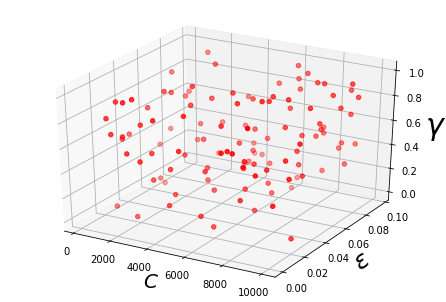





Best value iteration # 0 = 0.001065

Best value iteration # 1 = 0.000954

Best value iteration # 2 = 0.000867

Best value iteration # 3 = 0.000867

Best value iteration # 4 = 0.000867

Best value iteration # 5 = 0.000867

Best value iteration # 6 = 0.000867

Best value iteration # 7 = 0.000867

Best value iteration # 8 = 0.000867

Best value iteration # 9 = 0.000867

Best value iteration # 10 = 0.000867

Best value iteration # 11 = 0.000826

Best value iteration # 12 = 0.000826

Best value iteration # 13 = 0.000826

Best value iteration # 14 = 0.000825

Best value iteration # 15 = 0.000817

Best value iteration # 16 = 0.000817

Best value iteration # 17 = 0.000817

Best value iteration # 18 = 0.000817

Best value iteration # 19 = 0.000817

Best value iteration # 20 = 0.000817

Best value iteration # 21 = 0.000817

Best value iteration # 22 = 0.000811

Best value iteration # 23 = 0.000811

Best value iteration # 24 = 0.000811

Best value iteration # 25 = 0.000811

Best value iterati

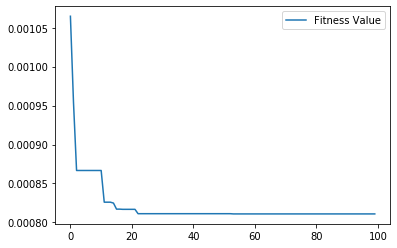

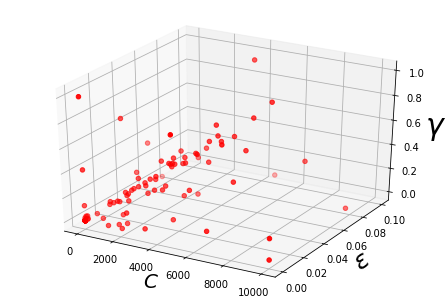





Predictions with the Population Best Value found:

Mean Squared Error for the Validation Set:	 0.000811






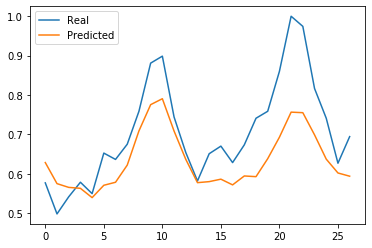





Mean Squared Error for the Test Set:	 0.010277




Predictions Average:	 0.635055




Predictions Median:	 0.602265




Predictions with the Average Best Group Value found:

Mean Squared Error for the Validation Set:	 0.000815






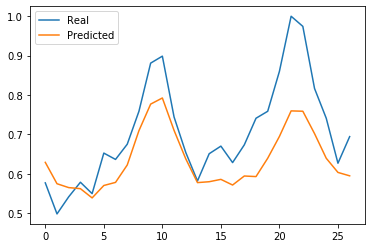





Mean Squared Error for the Test Set:	 0.010049




Predictions Average:	 0.635832




Predictions Median:	 0.603661




Predictions with the Median Group Value found:

Mean Squared Error for the Validation Set:	 0.000811






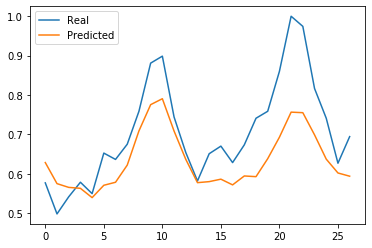





Mean Squared Error for the Test Set:	 0.010277




Predictions Average:	 0.635055




Predictions Median:	 0.602265






In [49]:
pso(120, 100, 3, 1)

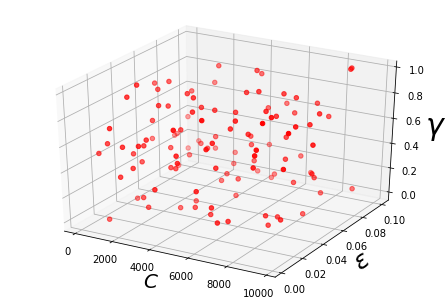





Best value iteration # 0 = 0.001046

Best value iteration # 1 = 0.000856

Best value iteration # 2 = 0.000847

Best value iteration # 3 = 0.000831

Best value iteration # 4 = 0.000831

Best value iteration # 5 = 0.000820

Best value iteration # 6 = 0.000820

Best value iteration # 7 = 0.000820

Best value iteration # 8 = 0.000820

Best value iteration # 9 = 0.000820

Best value iteration # 10 = 0.000820

Best value iteration # 11 = 0.000818

Best value iteration # 12 = 0.000818

Best value iteration # 13 = 0.000818

Best value iteration # 14 = 0.000818

Best value iteration # 15 = 0.000818

Best value iteration # 16 = 0.000818

Best value iteration # 17 = 0.000813

Best value iteration # 18 = 0.000813

Best value iteration # 19 = 0.000813

Best value iteration # 20 = 0.000813

Best value iteration # 21 = 0.000813

Best value iteration # 22 = 0.000808

Best value iteration # 23 = 0.000808

Best value iteration # 24 = 0.000808

Best value iteration # 25 = 0.000808

Best value iterati

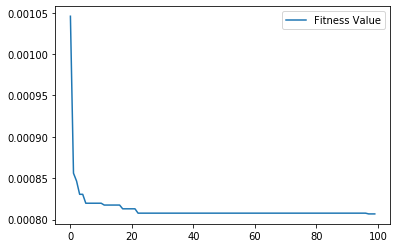

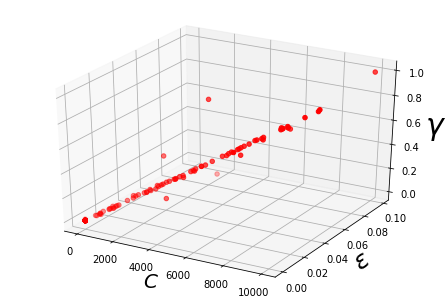





Predictions with the Population Best Value found:

Mean Squared Error for the Validation Set:	 0.000807






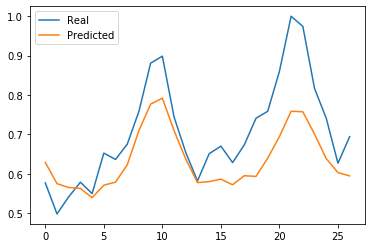





Mean Squared Error for the Test Set:	 0.010091




Predictions Average:	 0.635796




Predictions Median:	 0.603212




Predictions with the Average Best Group Value found:

Mean Squared Error for the Validation Set:	 0.000814






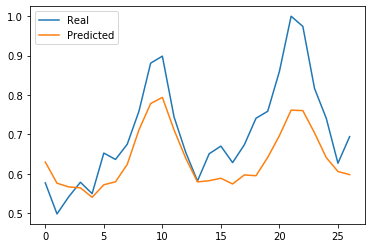





Mean Squared Error for the Test Set:	 0.009764




Predictions Average:	 0.637721




Predictions Median:	 0.605981




Predictions with the Median Group Value found:

Mean Squared Error for the Validation Set:	 0.000808






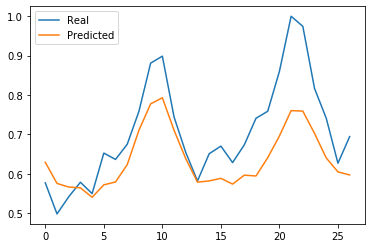





Mean Squared Error for the Test Set:	 0.009883




Predictions Average:	 0.637058




Predictions Median:	 0.605081






In [46]:
pso(120, 100, 3, 0.8)

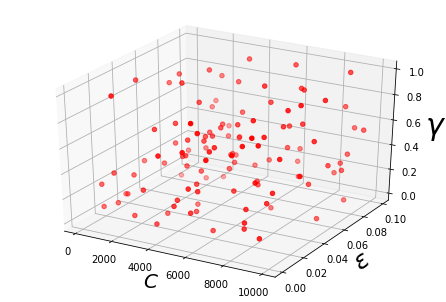





Best value iteration # 0 = 0.001074

Best value iteration # 1 = 0.000871

Best value iteration # 2 = 0.000864

Best value iteration # 3 = 0.000841

Best value iteration # 4 = 0.000841

Best value iteration # 5 = 0.000841

Best value iteration # 6 = 0.000832

Best value iteration # 7 = 0.000831

Best value iteration # 8 = 0.000819

Best value iteration # 9 = 0.000816

Best value iteration # 10 = 0.000816

Best value iteration # 11 = 0.000816

Best value iteration # 12 = 0.000816

Best value iteration # 13 = 0.000814

Best value iteration # 14 = 0.000814

Best value iteration # 15 = 0.000814

Best value iteration # 16 = 0.000814

Best value iteration # 17 = 0.000814

Best value iteration # 18 = 0.000814

Best value iteration # 19 = 0.000814

Best value iteration # 20 = 0.000814

Best value iteration # 21 = 0.000810

Best value iteration # 22 = 0.000810

Best value iteration # 23 = 0.000810

Best value iteration # 24 = 0.000810

Best value iteration # 25 = 0.000810

Best value iterati

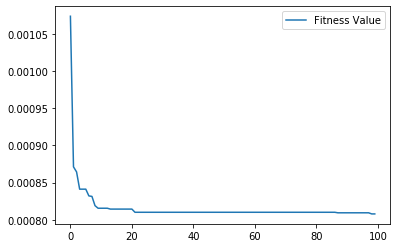

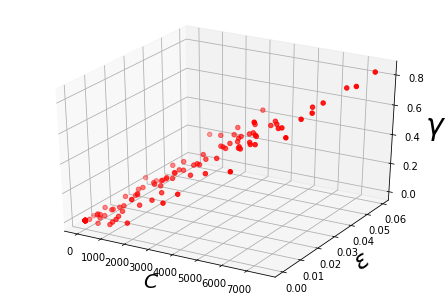





Predictions with the Population Best Value found:

Mean Squared Error for the Validation Set:	 0.000808






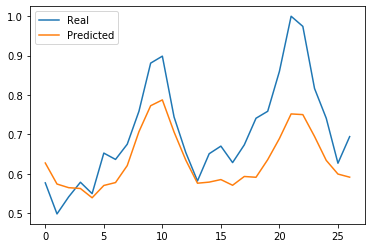





Mean Squared Error for the Test Set:	 0.010694




Predictions Average:	 0.633072




Predictions Median:	 0.599540




Predictions with the Average Best Group Value found:

Mean Squared Error for the Validation Set:	 0.000821






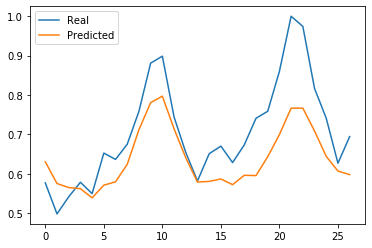





Mean Squared Error for the Test Set:	 0.009453




Predictions Average:	 0.638541




Predictions Median:	 0.607142




Predictions with the Median Group Value found:

Mean Squared Error for the Validation Set:	 0.000810






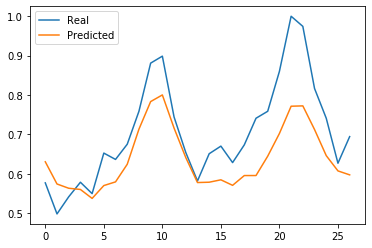





Mean Squared Error for the Test Set:	 0.009178




Predictions Average:	 0.639107




Predictions Median:	 0.607539






In [47]:
pso(120, 100, 3, 0.6)

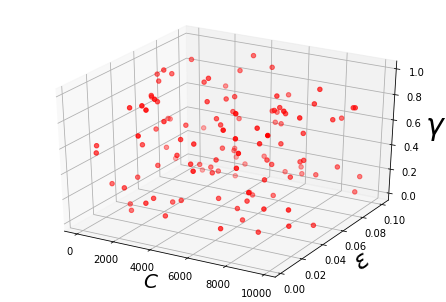





Best value iteration # 0 = 0.000885

Best value iteration # 1 = 0.000862

Best value iteration # 2 = 0.000816

Best value iteration # 3 = 0.000816

Best value iteration # 4 = 0.000816

Best value iteration # 5 = 0.000816

Best value iteration # 6 = 0.000816

Best value iteration # 7 = 0.000816

Best value iteration # 8 = 0.000815

Best value iteration # 9 = 0.000815

Best value iteration # 10 = 0.000813

Best value iteration # 11 = 0.000813

Best value iteration # 12 = 0.000813

Best value iteration # 13 = 0.000813

Best value iteration # 14 = 0.000813

Best value iteration # 15 = 0.000811

Best value iteration # 16 = 0.000811

Best value iteration # 17 = 0.000810

Best value iteration # 18 = 0.000810

Best value iteration # 19 = 0.000807

Best value iteration # 20 = 0.000807

Best value iteration # 21 = 0.000807

Best value iteration # 22 = 0.000807

Best value iteration # 23 = 0.000807

Best value iteration # 24 = 0.000807

Best value iteration # 25 = 0.000807

Best value iterati

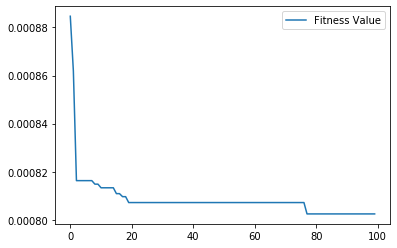

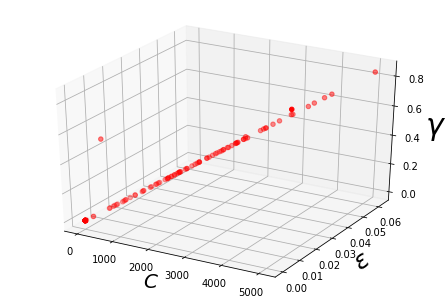





Predictions with the Population Best Value found:

Mean Squared Error for the Validation Set:	 0.000802






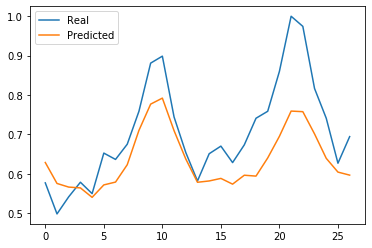





Mean Squared Error for the Test Set:	 0.009988




Predictions Average:	 0.636542




Predictions Median:	 0.604508




Predictions with the Average Best Group Value found:

Mean Squared Error for the Validation Set:	 0.000815






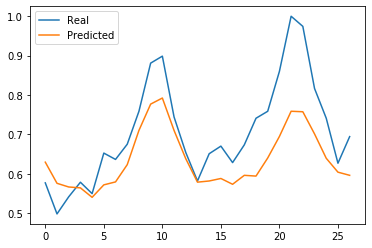





Mean Squared Error for the Test Set:	 0.010010




Predictions Average:	 0.636601




Predictions Median:	 0.604318




Predictions with the Median Group Value found:

Mean Squared Error for the Validation Set:	 0.000807






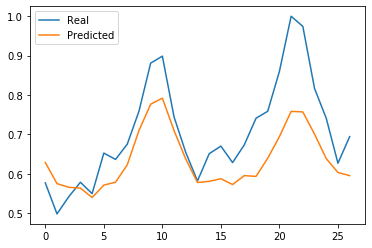





Mean Squared Error for the Test Set:	 0.010086




Predictions Average:	 0.635958




Predictions Median:	 0.603473






In [48]:
pso(120, 100, 3, 0.2)